# Impact of cut off points on transfer outcomes

We need to decide when we should consistently cut off the data to show a full picture of a month. The purpose of this analysis is to assess the impact of different cut off points. For example, if we cut off the data two weeks after the month end, we might have 1% of transfers that are shown in pending but will ultimately be successful, compared to doing it three weeks after the month end where we might ave 0.5% of transfers that are pending but ultimately successful. 

In [3]:
import paths
from datetime import datetime, date
from dateutil.tz import tzutc
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [4]:
from gp2gp.date.range import DateTimeRange
from gp2gp.pipeline.dashboard.main import read_spine_csv_gz_files
from gp2gp.service.transformers import derive_transfers
from scripts.gp2gp_spine_outcomes import parse_conversations

In [5]:
july_data_file_name = "../data/months/July-2020.csv.gz"
august_data_file_name = "../data/months/Aug-2020.csv.gz"
september_data_file_name="../data/months/Sept-2020.csv.gz"
october_data_file_name = "../data/months/Oct-2020.csv.gz"

In [6]:
july_time_range = DateTimeRange(
    datetime(year=2020, month=7, day=1, tzinfo=tzutc()),
    datetime(year=2020, month=8, day=1, tzinfo=tzutc()),
)

In [7]:
spine_messages = read_spine_csv_gz_files([
  july_data_file_name, august_data_file_name, september_data_file_name, october_data_file_name
])

conversations = parse_conversations(spine_messages, time_range=july_time_range)
transfers = derive_transfers(conversations)

In [8]:
transfers_df = pd.DataFrame(transfers)[["final_error_code", "intermediate_error_codes", "status", "date_completed"]]
transfers_df

,final_error_code,intermediate_error_codes,status,date_completed
0,NaN,[23],TransferStatus.FAILED,NaT
1,NaN,[20],TransferStatus.FAILED,NaT
2,NaN,[10],TransferStatus.FAILED,NaT
3,NaN,[10],TransferStatus.FAILED,NaT
4,NaN,[10],TransferStatus.FAILED,NaT
...,...,...,...,...
165064,NaN,[],TransferStatus.INTEGRATED,2020-07-01 06:39:08.615000+00:00
165065,NaN,[],TransferStatus.INTEGRATED,2020-07-01 06:38:55.183000+00:00
165066,NaN,[],TransferStatus.INTEGRATED,2020-07-01 06:38:33.343000+00:00
165067,NaN,[],TransferStatus.INTEGRATED,2020-07-01 05:49:42.736000+00:00


## Investigation into the final outcome of transfers with intermediate errors

In [33]:
total_number_transfers = len(transfers_df.index)
transfer_error_code_count = transfers_df["intermediate_error_codes"].map(lambda error_codes: len(error_codes))
transfers_with_intermediate_errors = transfers_df[transfer_error_code_count > 0]

In [34]:
transfers_with_intermediate_errors_df = pd.DataFrame(transfers_with_intermediate_errors)[["final_error_code", "intermediate_error_codes", "status", "date_completed",]]
transfers_with_intermediate_errors_df

,final_error_code,intermediate_error_codes,status,date_completed
0,NaN,[23],TransferStatus.FAILED,NaT
1,NaN,[20],TransferStatus.FAILED,NaT
2,NaN,[10],TransferStatus.FAILED,NaT
3,NaN,[10],TransferStatus.FAILED,NaT
4,NaN,[10],TransferStatus.FAILED,NaT
...,...,...,...,...
165024,NaN,[30],TransferStatus.FAILED,NaT
165026,NaN,[14],TransferStatus.FAILED,NaT
165037,NaN,[6],TransferStatus.FAILED,NaT
165051,NaN,[10],TransferStatus.FAILED,NaT


In [35]:
print(f"Total number of transfers: {total_number_transfers}")

Total number of transfers: 165069


In [36]:
def calculate_percentage(subset, total):
    return round((subset/total) * 100, 2)

In [37]:
total_number_transfers_with_intermediate_error_codes = len(transfers_with_intermediate_errors_df.index)

print(f"Total number of transfers with intermediate errors: {total_number_transfers_with_intermediate_error_codes}, out of a total transfer count of {total_number_transfers} ({calculate_percentage(total_number_transfers_with_intermediate_error_codes, total_number_transfers)}%) for transfers that began in the month of July (and cut off point being up until October)")

Total number of transfers with intermediate errors: 4348, out of a total transfer count of 165069 (2.63%) for transfers that began in the month of July (and cut off point being up until October)


In [38]:
eventually_integrated_count = transfers_with_intermediate_errors_df['date_completed'].notnull().sum()
percentage_eventually_integrated = calculate_percentage(eventually_integrated_count, total_number_transfers_with_intermediate_error_codes)

print(f"Transfers with intermediate errors that eventually integrate: {eventually_integrated_count} out of {total_number_transfers_with_intermediate_error_codes} ({percentage_eventually_integrated}%)")

Transfers with intermediate errors that eventually integrate: 340 out of 4348 (7.82%)


In [15]:
eventually_fails_count = transfers_with_intermediate_errors_df["final_error_code"].describe()["count"]
percentage_eventually_failed = calculate_percentage(eventually_fails_count, total_number_transfers_with_intermediate_error_codes)

print(f"Transfers with intermediate error codes that eventually failed: {eventually_fails_count} out of {total_number_transfers_with_intermediate_error_codes} ({percentage_eventually_failed}%)")

Transfers with intermediate error codes that eventually failed: 97.0 out of 4348 (2.23%)


In [39]:
unresolved_count = total_number_transfers_with_intermediate_error_codes - (eventually_fails_count + eventually_integrated_count)
percentage_unresolved = calculate_percentage(unresolved_count, total_number_transfers_with_intermediate_error_codes)

print(f"Transfers with intermediate error codes that are still pending: {unresolved_count} out of {total_number_transfers_with_intermediate_error_codes} ({percentage_unresolved})%")

Transfers with intermediate error codes that are still pending: 3911.0 out of 4348 (89.95)%


## Summary

In [40]:
print(f"Out of the total transfers, {calculate_percentage(eventually_integrated_count, total_number_transfers)}% have an intermediate error but eventually integrates.")
print(f"Out of the total transfers, {calculate_percentage(unresolved_count, total_number_transfers)}% have an intermediate error and are still pending.")

Out of the total transfers, 0.21% have an intermediate error but eventually integrates.
Out of the total transfers, 2.37% have an intermediate error and are still pending.


# Transfers completed over time

In [41]:
start_date = date(2020, 8, 1)
transfers_date_series = transfers_df["date_completed"].apply(lambda dt: (dt.date()-start_date).days if not pd.isnull(dt) else None)
transfers_date_df = transfers_date_series.to_frame(name="day_of_completion")
days_to_complete_df = transfers_date_df.groupby("day_of_completion").size().reset_index(name='counts')

In [42]:
filled_days_to_complete_df = pd.Series(range(-31,91)).to_frame("day_of_completion")
days_to_complete_df = pd.merge(filled_days_to_complete_df, days_to_complete_df, how="outer", on="day_of_completion").fillna(0)

The table below displays the accumulative completion of transfers initiated in a single month. Each row describes a day, starting from the first day of the month and ending several months later. The day_of_completion column numbers the days relative to the 1st day of the following month, which is numbered as day 0 (therefore we start with day -31 as the first day of the starting month). The counts column shows the number of transfers completed, and the percent_complete column tracks the day by day progress towards completion of all transfers initiated in the first month.

In [43]:
days_to_complete_df["percent_complete"] = (days_to_complete_df["counts"].cumsum()/total_number_transfers)*100
days_to_complete_df

,day_of_completion,counts,percent_complete
0,-31,3039.0,1.841048
1,-30,4690.0,4.682284
2,-29,4563.0,7.446583
3,-28,73.0,7.490807
4,-27,145.0,7.578649
...,...,...,...
118,87,12.0,95.197766
119,88,4.0,95.200189
120,89,19.0,95.211699
121,90,0.0,95.211699


In [47]:
def percentage_after_cut_off(days_to_complete_df, number_of_days):
    return round(days_to_complete_df.loc[days_to_complete_df["day_of_completion"] == number_of_days].iloc[0]["percent_complete"], 3)

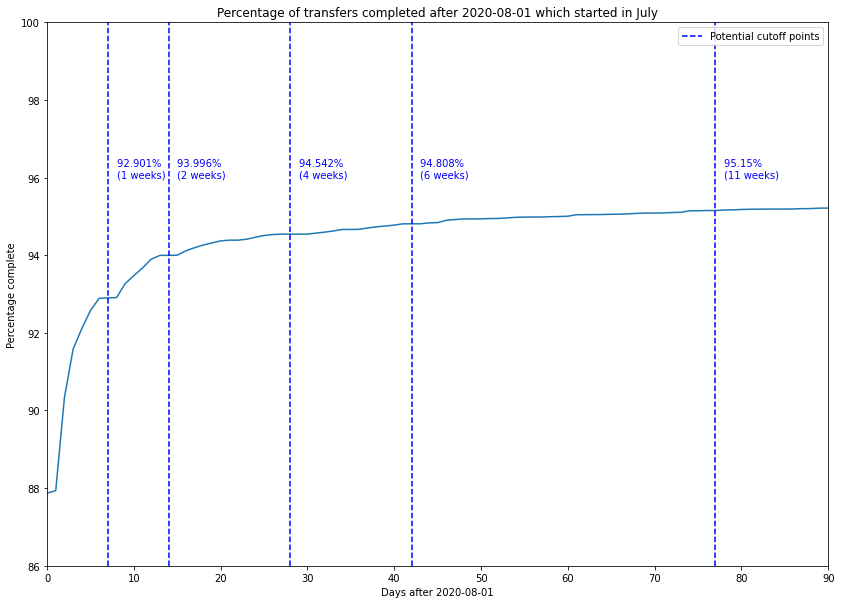

In [48]:
days_to_complete_plot = days_to_complete_df.plot.line(x="day_of_completion", y="percent_complete",
    title=f"Percentage of transfers completed after {start_date} which started in July", figsize=(14,10), legend=False)
days_to_complete_plot.set_xlim(0, 90)
days_to_complete_plot.set_ylim(86, 100)
days_to_complete_plot.set(xlabel=f"Days after {start_date}", ylabel="Percentage complete")


legend_elements = [Line2D([0], [0], color='blue', linestyle='--', label='Potential cutoff points')]
days_to_complete_plot.legend(handles=legend_elements)

for weeks in [1,2,4,6,11]:
    days = weeks*7
    days_to_complete_plot.axvline(days, color='blue', linestyle='--')
    days_to_complete_plot.text(s=f"{percentage_after_cut_off(days_to_complete_df, days)}% \n({weeks} weeks)", x=days+1, y=96, color='blue')

This graph shows how pending transfers continue to resolve after the end of a month. After 1 week 92% of transfers have been resolved while after 11 weeks 95% have been resolved.